# Movie recommendation using MovieLens data

Importing required packages

In [121]:
import pandas as pd
import graphlab
from sklearn.model_selection import train_test_split,KFold
from matplotlib import pyplot as plt
import numpy as np
import nltk

## Data exploration

Importing datasets from csv file

In [2]:
links = pd.read_csv("links.csv")
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

Exploring Links dataset

In [3]:
#checking the head of the links dataset (at movie ID level)
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
#checking the shape of the links dataset
links_shape = links.shape
print("Shape of links dataset = {}".format(links_shape))

Shape of links dataset = (9125, 3)


In [5]:
#number of unique movie Ids in the links dataset
uni_movieIds_links = links["movieId"].nunique()
print("No of unique movieIds in links dataset = {}".format(uni_movieIds_links))

No of unique movieIds in links dataset = 9125


In [6]:
#checking if a column has null values 
links.isnull().any()

movieId    False
imdbId     False
tmdbId      True
dtype: bool

In [7]:
#looking at rows with missing tmdbid
links[links["tmdbId"].isnull()].head()

,movieId,imdbId,tmdbId
607,720,118114,NaN
608,721,114103,NaN
640,769,116992,NaN
910,1133,111357,NaN
2282,2851,81454,NaN


In [8]:
#number of movies from which tmdbid is missing (13)
missing_tmdbId = links.loc[links["tmdbId"].isnull(), "movieId"].nunique()
print("{} movies have missing tmdbId".format(missing_tmdbId))

13 movies have missing tmdbId


In [9]:
#Replacing the missing TmdbId with Zero
links.loc[(links.tmdbId.isnull()) , "tmdbId"] = 0

Exploring Movies Dataset

In [10]:
#checking the head of the movies dataset (at movie ID level)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
#checking the shape of the movies dataset
movies_shape = movies.shape
print("Shape of movies dataset = {}".format(movies_shape))

Shape of movies dataset = (9125, 3)


In [12]:
#Data is unique at movie Id level
no_movies = movies["movieId"].nunique()
print("No of unique movies in movies dataset = {}".format(no_movies))

No of unique movies in movies dataset = 9125


In [13]:
#checking for mising values 
movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [14]:
#checking if the genres have not been listed
no_genre = movies.loc[movies.genres == "(no genres listed)"].movieId.count()
print("{} movies dont have genres listed".format(no_genre) )

18 movies dont have genres listed


In [15]:
#creating a new dataset with genres split into different columns
movies2 = pd.DataFrame(movies.genres.str.split('|').tolist(), columns = ["genres1","genres2","genres3","genres4","genres5","genres6","genres7","genres8","genres9","genres10"])

In [16]:
#concatenating the two datasets to create the final movies dataset
movies_new = pd.concat([movies,movies2],axis = 1)
movies_new.head()

,movieId,title,genres,genres1,genres2,genres3,genres4,genres5,genres6,genres7,genres8,genres9,genres10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None,None,None,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None,None,None,None,None


In [17]:
#creating the year of release dataset from the title column
movies_new["Year_release"] = movies_new['title'].str.extract('(\d\d\d\d)', expand=True)
movies_new.head()

,movieId,title,genres,genres1,genres2,genres3,genres4,genres5,genres6,genres7,genres8,genres9,genres10,Year_release
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,None,None,None,None,None,None,None,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None,None,None,None,None,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,None,None,None,None,1995
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None,None,None,None,None,1995


In [18]:
movies_new.isnull().any()

movieId         False
title           False
genres          False
genres1         False
genres2          True
genres3          True
genres4          True
genres5          True
genres6          True
genres7          True
genres8          True
genres9          True
genres10         True
Year_release     True
dtype: bool

In [19]:
#No of movies with missing year of release 
missing_year = movies_new.loc[movies_new['Year_release'].isnull(),'movieId'].nunique()
print("{} movies have missing year of release".format(missing_year))

4 movies have missing year of release


In [20]:
#Adding the missing Year_release for 4 movies manually
movies_new.loc[9017,"Year_release"] = "2015"
movies_new.loc[9063,"Year_release"] = "2016"
movies_new.loc[9118,"Year_release"] = "2016"
movies_new.loc[9124,"Year_release"] = "2014"

In [21]:
#merging the the links and movies datasets as both are on movie ID level
movies_links = pd.merge(movies_new,links, on = "movieId")
movies_links.head()
movies_links.shape
movies_links_shape = movies_links.shape
print("Shape of movies_links dataset = {}".format(movies_links_shape))

Shape of movies_links dataset = (9125, 16)


In [22]:
movies_links.isnull().any()

movieId         False
title           False
genres          False
genres1         False
genres2          True
genres3          True
genres4          True
genres5          True
genres6          True
genres7          True
genres8          True
genres9          True
genres10         True
Year_release    False
imdbId          False
tmdbId          False
dtype: bool

In [22]:
#storing movie and links data as Sframe
movies_links.to_csv("movies_links.csv")
movie_metadata = graphlab.SFrame.read_csv('movies_links.csv' )

This non-commercial license of GraphLab Create for academic use is assigned to dh2863@columbia.edu and will expire on November 02, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\hp\AppData\Local\Temp\graphlab_server_1509991816.log.0


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\movies_links.csv

Parsing completed. Parsed 100 lines in 0.086417 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,str,str,str,str,str,str,str,str,str,str,str,str,long,long,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\movies_links.csv

Parsing completed. Parsed 9125 lines in 0.053039 secs.

Exploring Ratings Data

In [23]:
#checking the head of the ratings data (unique at userID, movieID, timestamp level)
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [24]:
#checking the shape of the ratings data
ratings_shape = ratings.shape
print("{} is the shape of ratings data".format(ratings_shape))

(100004, 4) is the shape of ratings data


In [28]:
#No missing entries in ratings data
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [29]:
#No of unique users 671
m = ratings.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_ratings = m[2]
print("No of unique users who have rated a movie = {} ".format(uni_user))
print("No of unique movies that have been rated = {} ".format(uni_movies))
print("No of unique values of ratings = {} ".format(uni_ratings))

userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64
No of unique users who have rated a movie = 671 
No of unique movies that have been rated = 9066 
No of unique values of ratings = 10 


In [30]:
#unique values of ratings 
k = ratings['rating'].unique()
k = np.sort(k, kind= "quicksort")
print("Values of ratings =  {}".format(k))

Values of ratings =  [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]


In [31]:
#overall distribution of ratings 
ratings.groupby('rating').userId.count()

rating
0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: userId, dtype: int64

In [32]:
#Every customer has rated a movie only once
ratings.groupby(['userId','movieId']).userId.count().value_counts()

1    100004
Name: userId, dtype: int64

In [33]:
#converting time since epoch to datetime 
ratings["timestamp"] = pd.to_datetime(ratings['timestamp'], unit='ms')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1970-01-15 14:12:39.144
1,1,1029,3.0,1970-01-15 14:12:39.179
2,1,1061,3.0,1970-01-15 14:12:39.182
3,1,1129,2.0,1970-01-15 14:12:39.185
4,1,1172,4.0,1970-01-15 14:12:39.205


Explaoring Tags data

In [34]:
#checking tags data 
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [35]:
#converting time since epoch to datetime 
tags["timestamp"] = pd.to_datetime(tags['timestamp'], unit='ms')
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1970-01-14 04:15:37.770
1,15,1955,dentist,1970-01-14 19:30:35.061
2,15,7478,Cambodia,1970-01-14 13:09:20.997
3,15,32892,Russian,1970-01-14 13:10:26.366
4,15,34162,forgettable,1970-01-14 05:03:11.765


In [36]:
#shape of tags data
tags_shape = tags.shape
print("Shape of tags dataset = {}".format(tags_shape))

Shape of tags dataset = (1296, 4)


In [37]:
#No of unique values in tags dataset
m = tags.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_tags = m[2]
print("No of unique users who have tagged a movie = {} ".format(uni_user))
print("No of unique movies that have been tagged = {} ".format(uni_movies))
print("No of unique values of tags = {} ".format(uni_tags))

No of unique users who have tagged a movie = 61 
No of unique movies that have been tagged = 689 
No of unique values of tags = 582 


In [38]:
#checking Null values in the tags dataset
tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [39]:
#looking at data with more than 5 tags for a movie
df = tags.groupby(['userId','movieId']).count()
df.loc[df['tag'] > 5].head()

tag  timestamp
userId movieId                
138    48780      6          6
       79132      7          7
       109487    12         12
212    64957      8          8
       66097      7          7

In [40]:
#creating combined tag for a particular user movie combination
tags_new =tags.groupby(['userId','movieId'], as_index=False).sum()

In [41]:
tags_new.head()

,userId,movieId,tag
0,15,339,sandra 'boring' bullock
1,15,1955,dentist
2,15,7478,Cambodia
3,15,32892,Russian
4,15,34162,forgettable


In [42]:
#New shape of tags dataset
tags_shape = tags_new.shape
print("shape of tags dataset = {}".format(tags_shape))

shape of tags dataset = (772, 3)


In [43]:
#merging the ratings and tags data : information at user level
ratings_tags = pd.merge(ratings,tags_new[['userId','movieId','tag']],how = 'left', left_on = ['userId','movieId'], right_on = ['userId','movieId'])

In [44]:
#shape of the new ratings _tags dataset
ratings_tags_shape = ratings_tags.shape
print("shape of ratings_tags dataset = {}".format(ratings_tags_shape))

shape of ratings_tags dataset = (100004, 5)


In [45]:
#checking data for a particular entry
ratings_tags.loc[(ratings_tags.userId == 15) & (ratings_tags.movieId == 339)]

,userId,movieId,rating,timestamp,tag
1048,15,339,2.5,1970-01-13 23:49:36.622,sandra 'boring' bullock


In [46]:
#storing ratings and tags data as Sframe
ratings_tags.to_csv("ratings_tags.csv")
user_metadata = graphlab.SFrame.read_csv('ratings_tags.csv' )

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\ratings_tags.csv

Parsing completed. Parsed 100 lines in 0.1351 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,long,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\ratings_tags.csv

Parsing completed. Parsed 100004 lines in 0.148604 secs.

In [47]:
#Including the movie information to the ratings_tags data
all_data = pd.merge(ratings_tags, movies_links,how = 'left', left_on = ['movieId'], right_on = ['movieId'])

In [48]:
#checking the head of the combined data
all_data.head()

,userId,movieId,rating,timestamp,tag,title,genres,genres1,genres2,genres3,genres4,genres5,genres6,genres7,genres8,genres9,genres10,Year_release,imdbId,tmdbId
0,1,31,2.5,1970-01-15 14:12:39.144,NaN,Dangerous Minds (1995),Drama,Drama,None,None,None,None,None,None,None,None,None,1995,112792,9909.0
1,1,1029,3.0,1970-01-15 14:12:39.179,NaN,Dumbo (1941),Animation|Children|Drama|Musical,Animation,Children,Drama,Musical,None,None,None,None,None,None,1941,33563,11360.0
2,1,1061,3.0,1970-01-15 14:12:39.182,NaN,Sleepers (1996),Thriller,Thriller,None,None,None,None,None,None,None,None,None,1996,117665,819.0
3,1,1129,2.0,1970-01-15 14:12:39.185,NaN,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,Action,Adventure,Sci-Fi,Thriller,None,None,None,None,None,None,1981,82340,1103.0
4,1,1172,4.0,1970-01-15 14:12:39.205,NaN,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,Drama,None,None,None,None,None,None,None,None,None,1989,95765,11216.0


In [49]:
#shape of the combined data
all_data_shape = all_data.shape
print("shape of combined dataset = {}".format(all_data_shape))

shape of combined dataset = (100004, 20)


In [50]:
#converting the tags column to string type
all_data['tag'] = all_data['tag'].astype(str)

In [51]:
#checking data type of all columns 
all_data.dtypes

userId                   int64
movieId                  int64
rating                 float64
timestamp       datetime64[ns]
tag                     object
title                   object
genres                  object
genres1                 object
genres2                 object
genres3                 object
genres4                 object
genres5                 object
genres6                 object
genres7                 object
genres8                 object
genres9                 object
genres10                object
Year_release            object
imdbId                   int64
tmdbId                 float64
dtype: object

# Model based recommendation with Graphlabs

In [59]:
#splitting the data into test and train 80/20
train_data, test_data  = train_test_split(all_data , test_size=0.2, random_state=42)

In [60]:
#shape of train data
train_shape = train_data.shape
print("shape of train dataset = {}".format(train_shape))

shape of train dataset = (80003, 20)


In [61]:
#No of unique values in train data
m = train_data.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_ratings = m[2]
print("No of unique users who have rated a movie = {} ".format(uni_user))
print("No of unique movies that have been rated = {} ".format(uni_movies))
print("No of unique values of ratings = {} ".format(uni_ratings))

No of unique users who have rated a movie = 671 
No of unique movies that have been rated = 8399 
No of unique values of ratings = 10 


In [62]:
#shape of test dataset
test_shape = test_data.shape
print("shape of train dataset = {}".format(test_shape))

shape of train dataset = (20001, 20)


In [63]:
#No of unique values in test data
m = test_data.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_ratings = m[2]
print("No of unique users who have rated a movie = {} ".format(uni_user))
print("No of unique movies that have been rated = {} ".format(uni_movies))
print("No of unique values of ratings = {} ".format(uni_ratings))

No of unique users who have rated a movie = 671 
No of unique movies that have been rated = 4901 
No of unique values of ratings = 10 


In [68]:
#Keeping a copy of the test and train dataframes to use for sampling later
trainData = train_data
testData = test_data
#verifying
print(trainData.shape)
print(testData.shape)

(80003, 20)
(20001, 20)


In [69]:
#exporting the test and train dataset to csv 
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [71]:
#converting the test and train dataset to Sframe
hints = [int,int ,int ,float,str, str, str, str, str, str,str,str,str,str,str,str, str,str,float, int, float]
train = graphlab.SFrame.read_csv('train_data.csv',column_type_hints = hints )
test = graphlab.SFrame.read_csv('test_data.csv',column_type_hints = hints )

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data.csv

Parsing completed. Parsed 80003 lines in 0.425811 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\test_data.csv

Parsing completed. Parsed 20001 lines in 0.111292 secs.

Using the follwoing three approaches to solve the regression.
* Adaptive Gradient Stochastic Gradient Descent
* Stochastic Gradient Descent
* Alternating Least Squares

In [72]:
#building a factorization_recommender model using the graphLab package with 4 latent factors
#Using adaptive gradient stochastic descent 
m1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',solver= "adagrad" , user_data = user_metadata, item_data = movie_metadata, num_factors=4)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 0.995481s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.17115                                  |

| 2       | 0.152439          | 0.0612472                                |

| 3       | 0.0762195         | 0.0991312                                |

| 4       | 0.0381098         | 0.183782                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.152439          | 0.0612472                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.11836           | 1.05753               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 281.201ms    | 1.23684           | 1.11208               | 0.152439    |

| 2       | 537.382ms    | 0.615053          | 0.784194              | 0.152439    |

| 3       | 746.53ms     | 0.420464          | 0.648362              | 0.152439    |

| 4       | 965.185ms    | 0.345145          | 0.587411              | 0.152439    |

| 5       | 1.18s        | 0.295638          | 0.543638              | 0.152439    |

| 6       | 1.39s        | 0.257072          | 0.506925              | 0.152439    |

| 10      | 2.14s        | 0.162186          | 0.402586              | 0.152439    |

| 11      | 2.35s        | 0.146311          | 0.382359              | 0.152439    |

| 15      | 3.11s        | 0.0978467         | 0.31261               | 0.152439    |

| 20      | 4.03s        | 0.0632301         | 0.251196              | 0.152439    |

| 25      | 4.99s        | 0.0432315         | 0.207592              | 0.152439    |

| 30      | 5.93s        | 0.0309548         | 0.175537              | 0.152439    |

| 35      | 6.87s        | 0.0232996         | 0.152166              | 0.152439    |

| 40      | 7.80s        | 0.01858           | 0.135766              | 0.152439    |

| 45      | 8.73s        | 0.0150938         | 0.122247              | 0.152439    |

| 50      | 9.69s        | 0.0129969         | 0.11334               | 0.152439    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0138882

Final training RMSE: 0.117206

In [73]:
#Using stochastic gradient descent 
m2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId', user_data = user_metadata, item_data = movie_metadata ,solver= "sgd" , num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 1.61617s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | No Decrease (1.23591 >= 1.13522)         |

| 6       | 0.000297732       | No Decrease (1.64903 >= 1.13522)         |

| 7       | 7.44331e-005      | 1.03892                                  |

| 8       | 3.72166e-005      | 1.0527                                   |

| 9       | 1.86083e-005      | 1.06756                                  |

| 10      | 9.30414e-006      | 1.08287                                  |

+---------+-------------------+------------------------------------------+

| Final   | 7.44331e-005      | 1.03892                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.11834           | 1.05751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 479.339ms    | 1.00496           | 1.00248               |             |

| 2       | 787.782ms    | 0.97909           | 0.98949               |             |

| 3       | 1.15s        | 0.969444          | 0.984604              |             |

| 4       | 1.50s        | 0.965585          | 0.982642              |             |

| 5       | 1.86s        | 0.952305          | 0.975861              |             |

| 6       | 2.19s        | 0.95161           | 0.975505              |             |

| 10      | 3.27s        | 0.937652          | 0.968324              |             |

| 11      | 3.66s        | 0.934831          | 0.966867              |             |

| 15      | 4.77s        | 0.925719          | 0.962143              |             |

| 20      | 5.83s        | 0.917172          | 0.957691              |             |

| 25      | 6.48s        | 0.911948          | 0.95496               |             |

| 30      | 7.12s        | 0.908703          | 0.953259              |             |

| 35      | 7.75s        | 0.90726           | 0.952502              |             |

| 40      | 8.41s        | 0.906147          | 0.951918              |             |

| 45      | 9.07s        | 0.905464          | 0.951559              |             |

| 50      | 9.70s        | 0.905077          | 0.951355              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.905065

Final training RMSE: 0.951349

In [74]:
#Using Implicit Alternating Least Squares 
m3 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',solver= "als" ,user_data = user_metadata, item_data = movie_metadata , num_factors=4)


Recsys training: model = factorization_recommender

Warning: This solver currently does not support side features. Proceeding with training without side features.

Preparing data set.

Data has 80003 observations with 671 users and 8399 items.

Data prepared in: 0.782118s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 4        |

| regularization               | L2 Regularization on Factors                     | 1e-008   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 999us        | NA                     |

+---------+--------------+------------------------+

| 0       | 136.611ms    | 0.858793               |

| 1       | 221.672ms    | 0.804177               |

| 2       | 320.742ms    | 0.774129               |

| 3       | 420.448ms    | 0.755973               |

| 4       | 505.508ms    | 0.744064               |

| 5       | 593.753ms    | 0.735448               |

| 6       | 680.534ms    | 0.729416               |

| 7       | 761.06ms     | 0.724847               |

| 8       | 844.621ms    | 0.721106               |

| 9       | 937.685ms    | 0.718014               |

| 10      | 1.03s        | 0.715214               |

| 11      | 1.13s        | 0.712771               |

| 12      | 1.23s        | 0.710735               |

| 13      | 1.32s        | 0.708999               |

| 14      | 1.40s        | 0.707492               |

| 15      | 1.49s        | 0.70614                |

| 16      | 1.59s        | 0.704855               |

| 17      | 1.68s        | 0.703639               |

| 18      | 1.77s        | 0.702557               |

| 19      | 1.86s        | 0.701562               |

| 20      | 1.96s        | 0.700654               |

| 21      | 2.05s        | 0.699764               |

| 22      | 2.14s        | 0.698874               |

| 23      | 2.22s        | 0.698023               |

| 24      | 2.30s        | 0.697287               |

| 25      | 2.39s        | 0.696618               |

| 26      | 2.48s        | 0.695999               |

| 27      | 2.58s        | 0.695443               |

| 28      | 2.67s        | 0.69493                |

| 29      | 2.75s        | 0.694453               |

| 30      | 2.83s        | 0.69401                |

| 31      | 2.92s        | 0.693595               |

| 32      | 2.99s        | 0.693206               |

| 33      | 3.07s        | 0.692832               |

| 34      | 3.16s        | 0.692469               |

| 35      | 3.25s        | 0.692117               |

| 36      | 3.35s        | 0.691773               |

| 37      | 3.44s        | 0.691434               |

| 38      | 3.52s        | 0.691102               |

| 39      | 3.59s        | 0.690768               |

| 40      | 3.67s        | 0.690427               |

| 41      | 3.75s        | 0.690096               |

| 42      | 3.84s        | 0.689772               |

| 43      | 3.93s        | 0.689451               |

| 44      | 4.01s        | 0.689135               |

| 45      | 4.09s        | 0.688826               |

| 46      | 4.18s        | 0.688528               |

| 47      | 4.25s        | 0.688245               |

| 48      | 4.34s        | 0.687974               |

| 49      | 4.43s        | 0.687716               |

| FINAL   | 4.43s        | 0.687716               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Comparing the performance of the three models on the test data, to finalize the approach

In [60]:
 model_comp = graphlab.compare(test, [m1,m2, m3])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |  0.00298062593145 | 4.54208768326e-05 |
|   2    |  0.00149031296572 | 4.54208768326e-05 |
|   3    | 0.000993541977149 | 4.54208768326e-05 |
|   4    |  0.00111773472429 | 0.000160060335734 |
|   5    | 0.000894187779434 | 0.000160060335734 |
|   6    | 0.000745156482861 | 0.000160060335734 |
|   7    | 0.000638705556738 | 0.000160060335734 |
|   8    | 0.000558867362146 | 0.000160060335734 |
|   9    | 0.000496770988574 | 0.000160060335734 |
|   10   | 0.000596125186289 | 0.000238497860246 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+----

In [75]:
m1.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.612873853726 |
 |   3143  |   1   | 0.429013924694 |
 |   5684  |   1   | 1.52113013713  |
 |   2779  |   3   | 0.933228796413 |
 |   3988  |   4   | 1.09241422095  |
 |   2847  |   1   | 0.299188140434 |
 |  64614  |   9   | 0.700860623345 |
 |   2925  |   2   | 0.569762639691 |
 |   2871  |   5   | 1.15031923203  |
 |   3913  |   1   | 0.818596055241 |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.84911

In [62]:
m2.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+-----------------+
 | movieId | count |       rmse      |
 +---------+-------+-----------------+
 |   7899  |   2   |  0.522340933412 |
 |   3143  |   1   |  0.205963887482 |
 |   5684  |   1   |  2.06886128989  |
 |   2779  |   3   |  0.645115488303 |
 |   3988  |   4   |   1.022573678   |
 |   2847  |   1   |  0.107805869628 |
 |  64614  |   9   |  0.693141330215 |
 |   2925  |   2   |  0.475602542774 |
 |   2871  |   5   |  0.938756426007 |
 |   3913  |   1   | 0.0705656712917 |
 +---------+-------+-----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |  

In [76]:
m3.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.408983244419 |
 |   3143  |   1   | 0.458251565566 |
 |   5684  |   1   | 1.54174843443  |
 |   2779  |   3   |  1.2046916373  |
 |   3988  |   4   | 0.813569821433 |
 |   2847  |   1   | 0.59845843924  |
 |  64614  |   9   | 0.761183903438 |
 |   2925  |   2   | 1.44959885942  |
 |   2871  |   5   | 0.947890479543 |
 |   3913  |   1   | 0.199668466916 |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.70633

ADA model performance for different value of max iterations

In [77]:
#25 iterations
ada_m1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',solver= "adagrad",user_data = user_metadata, item_data = movie_metadata  ,max_iterations=25,num_factors=4)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 0.957236s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.104171                                 |

| 3       | 0.0381098         | 0.20625                                  |

| 4       | 0.0190549         | 0.361519                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.104171                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.11825           | 1.05747               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 331.735ms    | 0.897576          | 0.947388              | 0.0762195   |

| 2       | 620.439ms    | 0.565749          | 0.75214               | 0.0762195   |

| 3       | 927.656ms    | 0.426866          | 0.653321              | 0.0762195   |

| 4       | 1.21s        | 0.344087          | 0.586552              | 0.0762195   |

| 5       | 1.55s        | 0.287052          | 0.535727              | 0.0762195   |

| 6       | 1.86s        | 0.243785          | 0.493692              | 0.0762195   |

| 10      | 2.91s        | 0.142996          | 0.378057              | 0.0762195   |

| 11      | 3.21s        | 0.127244          | 0.356611              | 0.0762195   |

| 15      | 4.03s        | 0.0830173         | 0.287983              | 0.0762195   |

| 20      | 5.01s        | 0.0531445         | 0.23033               | 0.0762195   |

| 25      | 6.04s        | 0.0373237         | 0.192937              | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0331871

Final training RMSE: 0.181902

In [78]:
#50 iterations
ada_m2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,max_iterations=50,num_factors=4)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 0.973228s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.177405                                 |

| 2       | 0.152439          | 0.0654481                                |

| 3       | 0.0762195         | 0.0987136                                |

| 4       | 0.0381098         | 0.194035                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.152439          | 0.0654481                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.001ms      | 1.11833           | 1.05751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 268.71ms     | 1.1721            | 1.08258               | 0.152439    |

| 2       | 474.356ms    | 0.58973           | 0.767877              | 0.152439    |

| 3       | 690.508ms    | 0.407471          | 0.63826               | 0.152439    |

| 4       | 915.349ms    | 0.322908          | 0.568163              | 0.152439    |

| 5       | 1.15s        | 0.267094          | 0.516711              | 0.152439    |

| 6       | 1.48s        | 0.224573          | 0.473777              | 0.152439    |

| 10      | 2.54s        | 0.121491          | 0.348375              | 0.152439    |

| 11      | 2.83s        | 0.106085          | 0.325508              | 0.152439    |

| 15      | 3.72s        | 0.064045          | 0.252793              | 0.152439    |

| 20      | 6.49s        | 0.0378341         | 0.194126              | 0.152439    |

| 25      | 9.37s        | 0.0254399         | 0.159013              | 0.152439    |

| 30      | 11.84s       | 0.0184633         | 0.135295              | 0.152439    |

| 35      | 14.33s       | 0.0147251         | 0.120682              | 0.152439    |

| 40      | 16.44s       | 0.0121996         | 0.109712              | 0.152439    |

| 45      | 18.57s       | 0.0114458         | 0.106214              | 0.152439    |

| 50      | 19.77s       | 0.00966015        | 0.0974407             | 0.152439    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0119623

Final training RMSE: 0.108613

In [80]:
ada_m2['coefficients']

{'intercept': 3.5417484344337096, 'movieId': Columns:
 	movieId	int
 	linear_terms	float
 	factors	array
 
 Rows: 9125
 
 Data:
 +---------+--------------------+-------------------------------+
 | movieId |    linear_terms    |            factors            |
 +---------+--------------------+-------------------------------+
 |    1    |   0.102404944599   | [-0.312023937702, -0.05141... |
 |    2    |  0.0703761801124   | [-0.153851255774, -0.06863... |
 |    3    |  -0.138090670109   | [0.439986884594, 0.0623183... |
 |    4    |  -0.281930148602   | [0.258144617081, 0.2196142... |
 |    5    |   0.185211256146   | [0.0651989132166, -0.39491... |
 |    6    |   0.118924714625   | [0.330348193645, 0.2913644... |
 |    7    |  -0.0723969265819  | [-0.434919685125, -0.43319... |
 |    8    | -0.000643874052912 | [0.58164781332, -0.1067694... |
 |    9    |  0.0380612388253   | [0.579683661461, 0.2395905... |
 |    10   |  0.0249488372356   | [-0.0587613917887, 0.20702... |
 +---------+--

Creating a visualization of the Model to helps explore and qualitatively evaluate the recommendations made by the model

In [82]:
view = ada_m2.views.explore(train)
view.show()

View object

URI: 		http://localhost:32212/view/933d700b-f791-4e95-bd29-c55202ebf9ad
HTML: 		
<gl-recommender-explore
    uri="http://localhost:32212/view/131ef920-7a1e-4191-80f2-52358120876d"
    api_key=""
/>
        

In [69]:
 ada_model_iter = graphlab.compare(test, [ada_m1, ada_m2])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |        0.0        |        0.0        |
|   2    | 0.000745156482861 | 8.27951647624e-05 |
|   3    |  0.00149031296572 | 0.000311061068202 |
|   4    |  0.00111773472429 | 0.000311061068202 |
|   5    | 0.000894187779434 | 0.000311061068202 |
|   6    | 0.000993541977149 | 0.000476651397726 |
|   7    |  0.00106450926123 | 0.000497641721187 |
|   8    |  0.00111773472429 | 0.000503555661527 |
|   9    | 0.000993541977149 | 0.000503555661527 |
|   10   |  0.00104321907601 | 0.000506693162508 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+----

In [83]:
ada_m1.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.191592648828 |
 |   3143  |   1   | 0.234725949104 |
 |   5684  |   1   | 1.59879566772  |
 |   2779  |   3   | 1.52303128722  |
 |   3988  |   4   | 0.971305527676 |
 |   2847  |   1   | 0.681097631637 |
 |  64614  |   9   | 0.657623209602 |
 |   2925  |   2   | 0.412099789294 |
 |   2871  |   5   | 1.34029917568  |
 |   3913  |   1   | 0.25831775292  |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.74105

In [84]:
ada_m2.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.45693048359  |
 |   3143  |   1   | 0.740465724151 |
 |   5684  |   1   | 1.43961103432  |
 |   2779  |   3   | 1.07914969234  |
 |   3988  |   4   | 1.15282939067  |
 |   2847  |   1   | 0.488297998373 |
 |  64614  |   9   | 0.772381498031 |
 |   2925  |   2   | 0.143766005088 |
 |   2871  |   5   | 0.823893140134 |
 |   3913  |   1   | 0.418661601506 |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.96778

In [85]:
#use ada_m2 to predict ratings 
ada_m2.recommend(users=range(1,11),k=1000)

userId,movieId,score,rank
1,94466,3.88882499219,1
1,128620,3.87071913363,2
1,152081,3.73122478996,3
1,68269,3.63943767526,4
1,134853,3.62677704103,5
1,67504,3.6223518746,6
1,115713,3.61247356146,7
1,79824,3.5993067426,8
1,112852,3.59454272627,9
1,8264,3.57194275994,10


Model performance for different values of L2 regularization

In [86]:
ada_R1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-10,num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 0.979231s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-010   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.447448                                 |

| 2       | 0.152439          | 1.0735                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.304878          | 0.447448                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.11832           | 1.05751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 302.216ms    | DIVERGED          | DIVERGED              | 0.304878    |

| RESET   | 386.274ms    | 1.11854           | 1.05761               |             |

| 1       | 657.967ms    | 1.16307           | 1.07841               | 0.152439    |

| 2       | 912.148ms    | 0.585574          | 0.765205              | 0.152439    |

| 3       | 1.15s        | 0.38678           | 0.621907              | 0.152439    |

| 4       | 1.36s        | 0.296544          | 0.544555              | 0.152439    |

| 5       | 1.57s        | 0.238826          | 0.488697              | 0.152439    |

| 6       | 1.77s        | 0.194765          | 0.44132               | 0.152439    |

| 9       | 2.33s        | 0.112894          | 0.335995              | 0.152439    |

| 11      | 2.75s        | 0.0810018         | 0.284605              | 0.152439    |

| 14      | 3.38s        | 0.0525331         | 0.229197              | 0.152439    |

| 19      | 4.34s        | 0.0308748         | 0.175707              | 0.152439    |

| 24      | 5.30s        | 0.0197372         | 0.140482              | 0.152439    |

| 29      | 6.60s        | 0.0149098         | 0.122098              | 0.152439    |

| 34      | 7.71s        | 0.0137657         | 0.117319              | 0.152439    |

| 39      | 8.68s        | 0.00964944        | 0.0982214             | 0.152439    |

| 44      | 9.78s        | 0.00848919        | 0.0921259             | 0.152439    |

| 49      | 11.76s       | 0.00774949        | 0.0880197             | 0.152439    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.00712102

Final training RMSE: 0.0843742

In [87]:
ada_R2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-8,num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 1.84784s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.176849                                 |

| 2       | 0.152439          | 0.0674575                                |

| 3       | 0.0762195         | 0.0909855                                |

| 4       | 0.0381098         | 0.186031                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.152439          | 0.0674575                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.11832           | 1.05751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 700.997ms    | 1.15282           | 1.07364               | 0.152439    |

| 2       | 1.31s        | 0.635926          | 0.797389              | 0.152439    |

| 3       | 1.97s        | 0.392663          | 0.626551              | 0.152439    |

| 4       | 2.51s        | 0.285475          | 0.534203              | 0.152439    |

| 5       | 3.11s        | 0.223031          | 0.472147              | 0.152439    |

| 6       | 3.69s        | 0.179473          | 0.423509              | 0.152439    |

| 10      | 5.67s        | 0.0863577         | 0.293645              | 0.152439    |

| 11      | 6.09s        | 0.0746522         | 0.272981              | 0.152439    |

| 15      | 7.38s        | 0.0435871         | 0.208434              | 0.152439    |

| 20      | 8.30s        | 0.0266676         | 0.162845              | 0.152439    |

| 25      | 9.49s        | 0.0183598         | 0.134933              | 0.152439    |

| 30      | 10.60s       | 0.0139496         | 0.117449              | 0.152439    |

| 35      | 11.71s       | 0.0114165         | 0.10611               | 0.152439    |

| 40      | 13.10s       | 0.00988094        | 0.0986019             | 0.152439    |

| 45      | 14.24s       | 0.00839122        | 0.0907278             | 0.152439    |

| 50      | 15.18s       | 0.00844476        | 0.0910175             | 0.152439    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0096554

Final training RMSE: 0.0974414

In [88]:
ada_R3 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-6,num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 0.98176s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.19083                                  |

| 2       | 0.152439          | 0.0989767                                |

| 3       | 0.0762195         | 0.0970241                                |

| 4       | 0.0381098         | 0.207936                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.0970241                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.11833           | 1.05751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 259.192ms    | 0.909302          | 0.952236              | 0.0762195   |

| 2       | 466.551ms    | 0.566482          | 0.750598              | 0.0762195   |

| 3       | 847.321ms    | 0.445898          | 0.664969              | 0.0762195   |

| 4       | 1.36s        | 0.368736          | 0.603682              | 0.0762195   |

| 5       | 1.86s        | 0.313834          | 0.555869              | 0.0762195   |

| 6       | 2.38s        | 0.272042          | 0.516432              | 0.0762195   |

| 10      | 4.17s        | 0.168613          | 0.402009              | 0.0762195   |

| 11      | 4.70s        | 0.151531          | 0.379712              | 0.0762195   |

| 15      | 6.53s        | 0.102951          | 0.307317              | 0.0762195   |

| 20      | 9.54s        | 0.0698489         | 0.245589              | 0.0762195   |

| 25      | 11.78s       | 0.0516662         | 0.203563              | 0.0762195   |

| 30      | 14.03s       | 0.041271          | 0.174835              | 0.0762195   |

| 35      | 16.05s       | 0.034812          | 0.15418               | 0.0762195   |

| 40      | 17.59s       | 0.0305294         | 0.138709              | 0.0762195   |

| 45      | 18.94s       | 0.0276193         | 0.127068              | 0.0762195   |

| 50      | 20.28s       | 0.0254889         | 0.117798              | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0261211

Final training RMSE: 0.120451

In [215]:
ada_R4 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-4,num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 1.01172s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.25086                                  |

| 3       | 0.0381098         | 0.259849                                 |

| 4       | 0.0190549         | 0.352969                                 |

| 5       | 0.00952744        | 0.570494                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.25086                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.13365           | 1.06473               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 336.739ms    | 1.02624           | 0.942081              | 0.0762195   |

| 2       | 592.421ms    | 0.745374          | 0.777327              | 0.0762195   |

| 3       | 939.786ms    | 0.645036          | 0.699982              | 0.0762195   |

| 4       | 1.28s        | 0.585948          | 0.645614              | 0.0762195   |

| 5       | 1.59s        | 0.546637          | 0.604912              | 0.0762195   |

| 6       | 1.92s        | 0.519455          | 0.57397               | 0.0762195   |

| 10      | 3.10s        | 0.459643          | 0.499745              | 0.0762195   |

| 11      | 3.40s        | 0.44992           | 0.487433              | 0.0762195   |

| 15      | 4.41s        | 0.421583          | 0.452604              | 0.0762195   |

| 20      | 5.59s        | 0.395915          | 0.423431              | 0.0762195   |

| 25      | 6.70s        | 0.376148          | 0.402356              | 0.0762195   |

| 30      | 7.71s        | 0.359068          | 0.385014              | 0.0762195   |

| 35      | 8.70s        | 0.344883          | 0.37089               | 0.0762195   |

| 40      | 9.68s        | 0.332629          | 0.358752              | 0.0762195   |

| 45      | 10.69s       | 0.321444          | 0.347841              | 0.0762195   |

| 50      | 11.83s       | 0.310944          | 0.337642              | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.328782

Final training RMSE: 0.363098

In [216]:
ada_R5 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-2,num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.80607s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0920564         | 0.321279                                 |

| 1       | 0.0460282         | 0.466788                                 |

| 2       | 0.0230141         | 0.618665                                 |

| 3       | 0.0115071         | 0.990129                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0920564         | 0.321279                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.1336            | 1.0647                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 543.978ms    | DIVERGED          | DIVERGED              | 0.0920564   |

| RESET   | 669.568ms    | 1.13354           | 1.06468               |             |

| 1       | 961.275ms    | 1.08236           | 0.985246              | 0.0460282   |

| 2       | 1.24s        | 0.706129          | 0.833017              | 0.0460282   |

| 3       | 1.49s        | 0.659814          | 0.805933              | 0.0460282   |

| 4       | 1.82s        | 0.631588          | 0.789429              | 0.0460282   |

| 5       | 2.17s        | 0.608647          | 0.777215              | 0.0460282   |

| 6       | 2.47s        | 0.596069          | 0.769195              | 0.0460282   |

| 9       | 3.18s        | 0.563975          | 0.749946              | 0.0460282   |

| 11      | 3.67s        | 0.549633          | 0.740613              | 0.0460282   |

| 14      | 4.35s        | 0.531227          | 0.728454              | 0.0460282   |

| 19      | 5.62s        | 0.509555          | 0.71366               | 0.0460282   |

| 24      | 6.76s        | 0.493047          | 0.70206               | 0.0460282   |

| 29      | 7.87s        | 0.479112          | 0.692051              | 0.0460282   |

| 34      | 8.95s        | 0.467272          | 0.683492              | 0.0460282   |

| 39      | 10.04s       | 0.457123          | 0.676059              | 0.0460282   |

| 44      | 11.19s       | 0.447873          | 0.669154              | 0.0460282   |

| 49      | 12.26s       | 0.439586          | 0.662865              | 0.0460282   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.4336

Final training RMSE: 0.658397

Precision-Recall Plot of ada_R1,ada_R2,ada_R3,ada_R4,ada_R5

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    |       0.0        |        0.0        |
|   2    |       0.0        |        0.0        |
|   3    |       0.0        |        0.0        |
|   4    |      0.002       | 9.75609756098e-06 |
|   5    |      0.0016      | 9.75609756098e-06 |
|   6    | 0.00266666666667 | 1.43670485696e-05 |
|   7    | 0.00228571428571 | 1.43670485696e-05 |
|   8    |      0.002       | 1.43670485696e-05 |
|   9    | 0.00177777777778 | 1.43670485696e-05 |
|   10   |      0.0016      | 1.43670485696e-05 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------

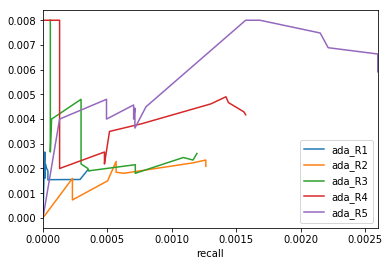

In [217]:
model_comp1 = graphlab.compare(test, [ada_R1,ada_R2,ada_R3,ada_R4,ada_R5],target='rating')
model_comp1_df = model_comp1.to_dataframe()

fig, ax = plt.subplots(1, 1)
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)    
    label1= model_comp1_df.loc[i,"model"]
    xy.plot(x='recall',y= 'precision',ax=ax,label=label1)
    
plt.show()


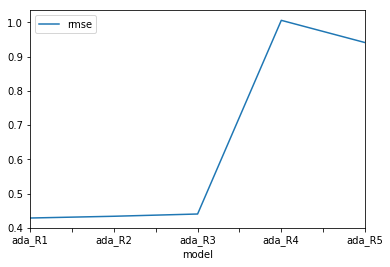

In [221]:
model_comp1 =graphlab.recommender.util.compare_models(test, [ada_R1,ada_R2,ada_R3,ada_R4,ada_R5], model_names=None,
                                         user_sample=1.0, metric='rmse',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=False, verbose=False)
#fig, ax = plt.subplots(1, 1)
rmse_data = {'model':['ada_R1','ada_R2','ada_R3','ada_R4','ada_R5'], 'rmse':[]}
for i in range(0,len(model_comp1)):
    rmse_data['rmse'].append(model_comp1[i]['rmse_overall'])
    

rmse_df=pd.DataFrame(rmse_data)
rmse_df.plot(x='model',y='rmse')
plt.show()

In [77]:
ada_R1.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.258587158942 |
 |   3143  |   1   | 0.747133156962 |
 |   5684  |   1   | 1.44507143119  |
 |   2779  |   3   | 0.926701275881 |
 |   3988  |   4   | 0.93650724547  |
 |   2847  |   1   | 0.221362879229 |
 |  64614  |   9   | 0.759506007397 |
 |   2925  |   2   | 1.33987519159  |
 |   2871  |   5   | 1.39284310725  |
 |   3913  |   1   | 0.36085953014  |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.91668

In [78]:
ada_R2.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.490269126276 |
 |   3143  |   1   | 0.226173744892 |
 |   5684  |   1   | 1.57510679373  |
 |   2779  |   3   | 0.835510381516 |
 |   3988  |   4   | 0.819734445408 |
 |   2847  |   1   | 0.110462617344 |
 |  64614  |   9   | 0.796728211145 |
 |   2925  |   2   | 0.927408188074 |
 |   2871  |   5   | 0.898754714723 |
 |   3913  |   1   | 0.235724501857 |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.78009

In [79]:
ada_R3.evaluate_rmse(test,target='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 4901
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   7899  |   2   | 0.591126191995 |
 |   3143  |   1   | 0.540916633661 |
 |   5684  |   1   | 1.39918696549  |
 |   2779  |   3   | 0.371713502663 |
 |   3988  |   4   | 1.02225046852  |
 |   2847  |   1   | 0.127944276775 |
 |  64614  |   9   | 0.675814668016 |
 |   2925  |   2   | 0.319005747806 |
 |   2871  |   5   | 0.803685322664 |
 |   3913  |   1   | 0.535754216071 |
 +---------+-------+----------------+
 [4901 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 671
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |  118   |   34  | 0.81687

In [101]:
ada_NF1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-6,num_factors=2)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 0.952677s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.134157                                 |

| 2       | 0.152439          | 0.115076                                 |

| 3       | 0.0762195         | 0.155691                                 |

| 4       | 0.0381098         | 0.28997                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.152439          | 0.115076                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.11834           | 1.05751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 240.682ms    | 1.04549           | 1.02028               | 0.152439    |

| 2       | 458.337ms    | 0.596868          | 0.769605              | 0.152439    |

| 3       | 712.016ms    | 0.456737          | 0.67214               | 0.152439    |

| 4       | 1.01s        | 0.381488          | 0.613269              | 0.152439    |

| 5       | 1.27s        | 0.332578          | 0.571637              | 0.152439    |

| 6       | 1.54s        | 0.294938          | 0.53733               | 0.152439    |

| 10      | 2.72s        | 0.192624          | 0.430039              | 0.152439    |

| 11      | 2.97s        | 0.176028          | 0.409906              | 0.152439    |

| 15      | 4.07s        | 0.126653          | 0.342948              | 0.152439    |

| 20      | 5.15s        | 0.092664          | 0.287657              | 0.152439    |

| 25      | 6.47s        | 0.0748482         | 0.25368               | 0.152439    |

| 30      | 7.85s        | 0.0633214         | 0.228977              | 0.152439    |

| 35      | 8.80s        | 0.0569124         | 0.213852              | 0.152439    |

| 40      | 10.13s       | 0.0518685         | 0.201187              | 0.152439    |

| 45      | 11.36s       | 0.0485658         | 0.19238               | 0.152439    |

| 50      | 12.71s       | 0.0453822         | 0.183549              | 0.152439    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0444807

Final training RMSE: 0.181077

In [100]:
ada_NF2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-6,num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 1.05579s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.213239                                 |

| 2       | 0.152439          | 0.0742027                                |

| 3       | 0.0762195         | 0.0910674                                |

| 4       | 0.0381098         | 0.192206                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.152439          | 0.0742027                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.11829           | 1.05749               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 306.717ms    | 1.1297            | 1.05871               | 0.152439    |

| 2       | 601.926ms    | 0.616101          | 0.779361              | 0.152439    |

| 3       | 908.143ms    | 0.390412          | 0.617325              | 0.152439    |

| 4       | 1.18s        | 0.292215          | 0.531258              | 0.152439    |

| 5       | 1.49s        | 0.230119          | 0.46854               | 0.152439    |

| 6       | 1.77s        | 0.187641          | 0.420101              | 0.152439    |

| 10      | 2.69s        | 0.0971766         | 0.29043               | 0.152439    |

| 11      | 2.91s        | 0.0853883         | 0.26881               | 0.152439    |

| 15      | 3.71s        | 0.0561002         | 0.205258              | 0.152439    |

| 20      | 4.69s        | 0.0400126         | 0.159576              | 0.152439    |

| 25      | 5.63s        | 0.0327942         | 0.133943              | 0.152439    |

| 30      | 6.59s        | 0.0293206         | 0.119583              | 0.152439    |

| 35      | 7.57s        | 0.0270933         | 0.109408              | 0.152439    |

| 40      | 8.52s        | 0.024669          | 0.0974262             | 0.152439    |

| 45      | 9.48s        | 0.0233905         | 0.0904705             | 0.152439    |

| 50      | 10.47s       | 0.023475          | 0.0908894             | 0.152439    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0229877

Final training RMSE: 0.0881678

In [99]:
ada_NF3 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-6,num_factors=6)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80003 observations with 671 users and 9125 items.

Data prepared in: 1.06178s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80003 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.0633071                                |

| 3       | 0.0381098         | 0.128392                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.0633071                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.1183            | 1.0575                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 410.805ms    | 0.92425           | 0.959411              | 0.0762195   |

| 2       | 712.019ms    | 0.554356          | 0.741555              | 0.0762195   |

| 3       | 1.10s        | 0.387991          | 0.618725              | 0.0762195   |

| 4       | 1.53s        | 0.301274          | 0.543577              | 0.0762195   |

| 5       | 1.90s        | 0.245031          | 0.488542              | 0.0762195   |

| 6       | 2.32s        | 0.203396          | 0.443326              | 0.0762195   |

| 10      | 3.91s        | 0.111875          | 0.321663              | 0.0762195   |

| 11      | 4.29s        | 0.0986962         | 0.299962              | 0.0762195   |

| 15      | 5.40s        | 0.0625682         | 0.229918              | 0.0762195   |

| 20      | 6.70s        | 0.0406081         | 0.173446              | 0.0762195   |

| 25      | 8.14s        | 0.0298668         | 0.137219              | 0.0762195   |

| 30      | 10.10s       | 0.0240799         | 0.112752              | 0.0762195   |

| 35      | 11.98s       | 0.0206288         | 0.0951197             | 0.0762195   |

| 40      | 13.41s       | 0.0186797         | 0.0833888             | 0.0762195   |

| 45      | 14.71s       | 0.0173064         | 0.0740382             | 0.0762195   |

| 50      | 15.96s       | 0.0162919         | 0.0663193             | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0169506

Final training RMSE: 0.0711118

In [194]:
ada_NF4 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-6,num_factors=8)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.919025s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.0892127                                |

| 3       | 0.0381098         | 0.114662                                 |

| 4       | 0.0190549         | 0.239331                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.0892127                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13355           | 1.06468               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 400.284ms    | 0.956827          | 0.975694              | 0.0762195   |

| 2       | 680.482ms    | 0.546517          | 0.735514              | 0.0762195   |

| 3       | 1.01s        | 0.361911          | 0.596302              | 0.0762195   |

| 4       | 1.29s        | 0.267128          | 0.509987              | 0.0762195   |

| 5       | 1.59s        | 0.206589          | 0.446046              | 0.0762195   |

| 6       | 1.87s        | 0.164269          | 0.39512               | 0.0762195   |

| 10      | 2.75s        | 0.0802777         | 0.265744              | 0.0762195   |

| 11      | 3.01s        | 0.0693772         | 0.243813              | 0.0762195   |

| 15      | 3.86s        | 0.0428438         | 0.179114              | 0.0762195   |

| 20      | 4.95s        | 0.0283328         | 0.130197              | 0.0762195   |

| 25      | 6.02s        | 0.0217892         | 0.100267              | 0.0762195   |

| 30      | 7.11s        | 0.0191987         | 0.0851735             | 0.0762195   |

| 35      | 8.20s        | 0.0167015         | 0.0680439             | 0.0762195   |

| 40      | 9.24s        | 0.0156453         | 0.0591501             | 0.0762195   |

| 45      | 10.33s       | 0.0150933         | 0.0538663             | 0.0762195   |

| 50      | 11.46s       | 0.0144044         | 0.0467613             | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0144455

Final training RMSE: 0.0471986

In [195]:
ada_NF5 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "adagrad" ,regularization=1e-6,num_factors=10)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.802799s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.0485163                                |

| 3       | 0.0381098         | 0.0893381                                |

| 4       | 0.0190549         | 0.218729                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.0485163                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.1336            | 1.06471               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 473.834ms    | 0.990134          | 0.992026              | 0.0762195   |

| 2       | 906.14ms     | 0.527706          | 0.721814              | 0.0762195   |

| 3       | 1.36s        | 0.325852          | 0.564171              | 0.0762195   |

| 4       | 1.80s        | 0.223945          | 0.464366              | 0.0762195   |

| 5       | 2.24s        | 0.163044          | 0.392585              | 0.0762195   |

| 6       | 2.68s        | 0.124364          | 0.33902               | 0.0762195   |

| 10      | 4.48s        | 0.0539354         | 0.207711              | 0.0762195   |

| 11      | 4.86s        | 0.0459642         | 0.186934              | 0.0762195   |

| 15      | 6.18s        | 0.0283292         | 0.129169              | 0.0762195   |

| 20      | 7.91s        | 0.0200338         | 0.0893704             | 0.0762195   |

| 25      | 9.64s        | 0.0167033         | 0.0668243             | 0.0762195   |

| 30      | 11.39s       | 0.0151764         | 0.0533779             | 0.0762195   |

| 35      | 13.01s       | 0.0146057         | 0.0473433             | 0.0762195   |

| 40      | 14.70s       | 0.0140943         | 0.0415008             | 0.0762195   |

| 45      | 16.33s       | 0.0136919         | 0.0364631             | 0.0762195   |

| 50      | 17.91s       | 0.0134564         | 0.0333898             | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0132689

Final training RMSE: 0.0304527

In [213]:
model_comp1 = graphlab.compare(test, [ada_NF1,ada_NF2,ada_NF3,ada_NF4,ada_NF5],target='rating')
model_comp1_df = model_comp1.to_dataframe()

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |        0.0        |        0.0        |
|   2    |       0.004       | 9.75609756098e-06 |
|   3    |  0.00266666666667 | 9.75609756098e-06 |
|   4    |       0.002       | 9.75609756098e-06 |
|   5    |       0.0016      | 9.75609756098e-06 |
|   6    |  0.00133333333333 | 9.75609756098e-06 |
|   7    |  0.00114285714286 | 9.75609756098e-06 |
|   8    |       0.001       | 9.75609756098e-06 |
|   9    | 0.000888888888889 | 9.75609756098e-06 |
|   10   |       0.0008      | 9.75609756098e-06 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+----

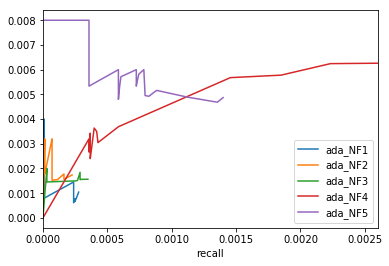

In [214]:
fig, ax = plt.subplots(1, 1)
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)    
    #xy.plot(x='recall',y= 'precision',ax=ax)
    label1= model_comp1_df.loc[i,"model"]
    xy.plot(x='recall',y= 'precision',ax=ax,label=label1)
    
plt.show()

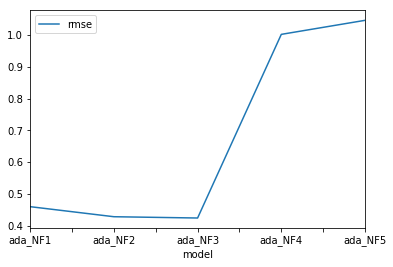

In [202]:
model_comp1 =graphlab.recommender.util.compare_models(test, [ada_NF1,ada_NF2,ada_NF3,ada_NF4,ada_NF5], model_names=None,
                                         user_sample=1.0, metric='rmse',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=False, verbose=False)
#fig, ax = plt.subplots(1, 1)
rmse_data = {'model':['ada_NF1','ada_NF2','ada_NF3','ada_NF4','ada_NF5'], 'rmse':[]}
for i in range(0,len(model_comp1)):
    rmse_data['rmse'].append(model_comp1[i]['rmse_overall'])
    

rmse_df=pd.DataFrame(rmse_data)
rmse_df.plot(x='model',y='rmse')
plt.show()


# Evaluating Model Performance For Different Sample Sizes

In [94]:
train_sample1 = trainData.sample(frac =0.25,replace =False)
train_sample2 = trainData.sample(frac =0.5,replace =False)
train_sample3 = trainData.sample(frac =0.75,replace =False)
print("Training sample-1 shape - {}".format(train_sample1.shape))
print("Training sample-2 shape - {}".format(train_sample2.shape))
print("Training sample-3 shape - {}".format(train_sample3.shape))

Training sample-1 shape - (20001, 20)
Training sample-2 shape - (40002, 20)
Training sample-3 shape - (60002, 20)


In [96]:
#converting data to csv for Sframe parsing
train_sample1.to_csv("train_data1.csv")
train_sample2.to_csv("train_data2.csv")
train_sample3.to_csv("train_data3.csv")

In [97]:
#converting the train datasets to Sframe
hints = [int,int ,int ,float,str, str, str, str, str, str,str,str,str,str,str,str, str,str,float, int, float]
train1 = graphlab.SFrame.read_csv('train_data1.csv',column_type_hints = hints )
train2 = graphlab.SFrame.read_csv('train_data2.csv',column_type_hints = hints )
train3 = graphlab.SFrame.read_csv('train_data3.csv',column_type_hints = hints )

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data1.csv

Parsing completed. Parsed 20001 lines in 0.159123 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data2.csv

Parsing completed. Parsed 40002 lines in 0.220673 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data3.csv

Parsing completed. Parsed 60002 lines in 0.300706 secs.

Building a factorization_recommender model using the graphLab package with 4 latent factors
Using adaptive gradient stochastic descent 

In [104]:
m1_t1 = graphlab.factorization_recommender.create(train1, target='rating', user_id='userId',
                                               item_id='movieId',solver= "adagrad" , user_data = user_metadata,
                                               item_data = movie_metadata, num_factors=4)
m1_t2 = graphlab.factorization_recommender.create(train2, target='rating', user_id='userId',
                                               item_id='movieId',solver= "adagrad" , user_data = user_metadata,
                                               item_data = movie_metadata, num_factors=4)
m1_t3 = graphlab.factorization_recommender.create(train3, target='rating', user_id='userId',
                                               item_id='movieId',solver= "adagrad" , user_data = user_metadata,
                                               item_data = movie_metadata, num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 20001 observations with 671 users and 9125 items.

Data prepared in: 0.556479s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 20001 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.0941477                                |

| 3       | 0.0381098         | 0.200827                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.0941477                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.11662           | 1.0567                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 111.08ms     | 1.03662           | 1.01814               | 0.0762195   |

| 2       | 200.642ms    | 0.588354          | 0.767034              | 0.0762195   |

| 3       | 292.708ms    | 0.384482          | 0.620055              | 0.0762195   |

| 4       | 391.778ms    | 0.275801          | 0.525153              | 0.0762195   |

| 5       | 479.914ms    | 0.207604          | 0.455617              | 0.0762195   |

| 6       | 564.474ms    | 0.157693          | 0.397082              | 0.0762195   |

| 11      | 945.244ms    | 0.0528414         | 0.22982               | 0.0762195   |

| 25      | 1.95s        | 0.00535266        | 0.0729621             | 0.0762195   |

| 50      | 4.14s        | 0.000747974       | 0.0267821             | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.000758322

Final training RMSE: 0.0269746

Recsys training: model = factorization_recommender

Preparing data set.

Data has 40002 observations with 671 users and 9125 items.

Data prepared in: 0.836615s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 40002 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | 0.197496                                 |

| 2       | 0.152439          | 0.0742522                                |

| 3       | 0.0762195         | 0.100476                                 |

| 4       | 0.0381098         | 0.182538                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.152439          | 0.0742522                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13268           | 1.06427               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 190.815ms    | DIVERGED          | DIVERGED              | 0.152439    |

| RESET   | 246.351ms    | 1.13224           | 1.06407               |             |

| 1       | 386.453ms    | 0.974197          | 0.987004              | 0.0762195   |

| 2       | 513.54ms     | 0.566733          | 0.752802              | 0.0762195   |

| 3       | 637.13ms     | 0.403874          | 0.635492              | 0.0762195   |

| 4       | 771.723ms    | 0.309764          | 0.55654               | 0.0762195   |

| 5       | 941.844ms    | 0.247167          | 0.497128              | 0.0762195   |

| 6       | 1.08s        | 0.203384          | 0.450945              | 0.0762195   |

| 9       | 1.56s        | 0.121616          | 0.348677              | 0.0762195   |

| 11      | 1.85s        | 0.0899767         | 0.299889              | 0.0762195   |

| 19      | 3.01s        | 0.0325458         | 0.180257              | 0.0762195   |

| 29      | 4.08s        | 0.0120901         | 0.109685              | 0.0762195   |

| 39      | 5.71s        | 0.00604713        | 0.0773643             | 0.0762195   |

| 49      | 6.85s        | 0.0036241         | 0.0596724             | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.00335071

Final training RMSE: 0.0573351

Recsys training: model = factorization_recommender

Preparing data set.

Data has 60002 observations with 671 users and 9125 items.

Data prepared in: 0.987247s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 60002 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.122616                                 |

| 3       | 0.0381098         | 0.18985                                  |

| 4       | 0.0190549         | 0.362523                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.122616                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.11955           | 1.05809               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 230.664ms    | 0.918287          | 0.958259              | 0.0762195   |

| 2       | 435.308ms    | 0.566719          | 0.752789              | 0.0762195   |

| 3       | 622.942ms    | 0.419497          | 0.647662              | 0.0762195   |

| 4       | 907.644ms    | 0.333273          | 0.577268              | 0.0762195   |

| 5       | 1.16s        | 0.268948          | 0.518564              | 0.0762195   |

| 6       | 1.41s        | 0.225439          | 0.474758              | 0.0762195   |

| 10      | 2.24s        | 0.125442          | 0.354099              | 0.0762195   |

| 11      | 2.50s        | 0.109729          | 0.331166              | 0.0762195   |

| 15      | 3.11s        | 0.067958          | 0.260559              | 0.0762195   |

| 20      | 4.00s        | 0.0409124         | 0.202085              | 0.0762195   |

| 25      | 4.99s        | 0.0266985         | 0.163155              | 0.0762195   |

| 30      | 5.93s        | 0.0188161         | 0.136871              | 0.0762195   |

| 35      | 7.06s        | 0.0142324         | 0.118944              | 0.0762195   |

| 40      | 8.06s        | 0.0111877         | 0.105363              | 0.0762195   |

| 45      | 9.15s        | 0.00888479        | 0.0937927             | 0.0762195   |

| 50      | 9.98s        | 0.00744402        | 0.0857629             | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.00718614

Final training RMSE: 0.084246

In [106]:
graphlab.recommender.util.compare_models(test, [m1_t1,m1_t2,m1_t3,m1], model_names=["m1_t1","m1_t2","m1_t3","m1"],
                                         user_sample=1.0, metric='auto',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=True, verbose=False)

[{'precision_recall_by_user': Columns:
  	userId	int
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 12078
  
  Data:
  +--------+--------+-----------+--------+-------+
  | userId | cutoff | precision | recall | count |
  +--------+--------+-----------+--------+-------+
  |   1    |   1    |    0.0    |  0.0   |   1   |
  |   1    |   2    |    0.0    |  0.0   |   1   |
  |   1    |   3    |    0.0    |  0.0   |   1   |
  |   1    |   4    |    0.0    |  0.0   |   1   |
  |   1    |   5    |    0.0    |  0.0   |   1   |
  |   1    |   6    |    0.0    |  0.0   |   1   |
  |   1    |   7    |    0.0    |  0.0   |   1   |
  |   1    |   8    |    0.0    |  0.0   |   1   |
  |   1    |   9    |    0.0    |  0.0   |   1   |
  |   1    |   10   |    0.0    |  0.0   |   1   |
  +--------+--------+-----------+--------+-------+
  [12078 rows x 5 columns]
  Note: Only the head of the SFrame is printed.
  You can use print_rows(num_rows=m, num_columns=n) to print more ro

In [111]:
model_comp1 = graphlab.compare(test, [m1_t1,m1_t2,m1_t3,m1],target='rating')

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    | 0.00447093889717 | 0.000156224591503 |
|   2    | 0.00596125186289 | 0.000330269559829 |
|   3    | 0.00645802285147 | 0.000440660336457 |
|   4    | 0.00931445603577 |  0.00107448633492 |
|   5    | 0.0104321907601  |  0.00165845296483 |
|   6    | 0.0101838052658  |  0.00210994116668 |
|   7    | 0.0108579944646  |  0.00260936954202 |
|   8    | 0.0109910581222  |  0.00285313909571 |
|   9    | 0.0112601424077  |  0.00347953670471 |
|   10   | 0.0110283159463  |  0.00361615684896 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+---------

# Plotting Model Performance Using The Evaluation Results (to-do)

In [112]:
model_comp1.dtype

<bound method SFrame.dtype of Columns:
	dataset	str
	metric	str
	model	str
	model_type	str
	results	dict

Rows: 4

Data:
+---------+------------------+-------+--------------------------+
| dataset |      metric      | model |        model_type        |
+---------+------------------+-------+--------------------------+
|   test  | precision_recall | m1_t1 | FactorizationRecommender |
|   test  | precision_recall | m1_t2 | FactorizationRecommender |
|   test  | precision_recall | m1_t3 | FactorizationRecommender |
|   test  | precision_recall |   m1  | FactorizationRecommender |
+---------+------------------+-------+--------------------------+
+-------------------------------+
|            results            |
+-------------------------------+
| {'precision_recall': [{'cu... |
| {'precision_recall': [{'cu... |
| {'precision_recall': [{'cu... |
| {'precision_recall': [{'cu... |
+-------------------------------+
[4 rows x 5 columns]
>

In [140]:
model_comp1_df = model_comp1.to_dataframe()
xy_dict= model_comp1_df.loc[0,"results"]
xy_dict

{'precision_recall': [{'cutoff': 1L,
   'precision': 0.004470938897168406,
   'recall': 0.00015622459150311195},
  {'cutoff': 2L,
   'precision': 0.005961251862891207,
   'recall': 0.0003302695598287216},
  {'cutoff': 3L,
   'precision': 0.006458022851465465,
   'recall': 0.00044066033645654096},
  {'cutoff': 4L,
   'precision': 0.009314456035767518,
   'recall': 0.0010744863349203277},
  {'cutoff': 5L,
   'precision': 0.01043219076005961,
   'recall': 0.0016584529648299758},
  {'cutoff': 6L,
   'precision': 0.0101838052657725,
   'recall': 0.002109941166684525},
  {'cutoff': 7L,
   'precision': 0.01085799446455184,
   'recall': 0.00260936954201835},
  {'cutoff': 8L,
   'precision': 0.010991058122205652,
   'recall': 0.002853139095712694},
  {'cutoff': 9L,
   'precision': 0.011260142407683403,
   'recall': 0.0034795367047106857},
  {'cutoff': 10L,
   'precision': 0.011028315946348724,
   'recall': 0.003616156848960651},
  {'cutoff': 11L,
   'precision': 0.01070315675382739,
   'recall'

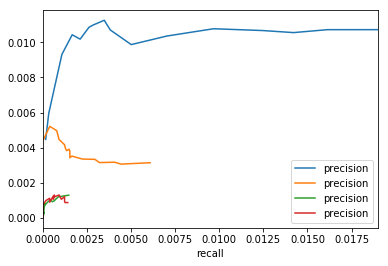

In [166]:
fig, ax = plt.subplots(1, 1)
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)    
    xy.plot(x='recall',y= 'precision',ax=ax)
plt.show()

# Cross Validation 

In [158]:
#K-Fold data split
all_data.to_csv("full_dataset.csv")
hints = [int,int ,int ,float,str, str, str, str, str, str,str,str,str,str,str,str, str,str,float, int, float]
data = graphlab.SFrame.read_csv('full_dataset.csv',column_type_hints= hints)
kfolds = graphlab.cross_validation.KFold(data, 5)
#for train, test in kfolds:    
#    model = graphlab.factorization_recommender.create(train, target='rating', user_id='userId',
#                                               item_id='movieId',solver= "adagrad" , user_data = user_metadata,
#                                               item_data = movie_metadata, num_factors=4)
#    print(model.evaluate(test))

params = dict([('target', 'rating'), ('user_id', 'userId'), ('item_id', 'movieId'), ('solver', 'adagrad')
               , ('user_data', 'user_metadata'), ('item_data', 'movie_metadata'), ('num_factors', '4')])
graphlab.toolkits.cross_validation.cross_val_score(kfolds, graphlab.factorization_recommender.create, params)

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\full_dataset.csv

Parsing completed. Parsed 100004 lines in 0.820563 secs.

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Cross-Validation-Nov-07-2017-09-53-21-467000--1249231' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Cross-Validation-Nov-07-2017-09-53-21-467000--1249231' scheduled.


Info
------
Job                : Cross-Validation-Nov-07-2017-09-53-21-467000--1249231
Function(s)        : _train_test_model-0-0, _train_test_model-0-1, _train_test_model-0-2 ... (total 6 functions).
Status             : Pending

Help
------
Visualize progress : self.show()
Query status       : self.get_status()
Get results        : self.get_results()

Environment
----------
LocalAsync: ["name": async]

Metrics
-------
Start time         : None
End time           : None
None

Execution Information
---------------------
Process pid          : 14660
Execution Directory  : C:\Users\hp\.graphlab\artifacts/results\job-results-4fe42d11-8f37-4d88-bc4b-3a3b367e7ec5
Log file             : C:\Users\hp\.graphlab\artifacts/results\job-results-4fe42d11-8f37-4d88-bc4b-3a3b367e7ec5\execution.log

NameError: name 'self' is not defined